# Rice leaf classification


## Introduction
This code aims to select a CNN model which classified the rice leaf diseases dataset best, then fine tune the selected model. <br> <br>

# 1. Import libraries

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
from torchvision.utils import make_grid
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
from torchvision import transforms
import pandas as pd
from PIL import Image
from glob import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.svm import SVC
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Load data ##

In [3]:
class CustomImageDataset(Dataset):
  def __init__(self, csv_file, transform=None):
    self.data_frame = pd.read_csv(csv_file)
    self.transform = transform
    self.classes = sorted(self.data_frame['class'].unique())
    self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

  def __len__(self):
    return len(self.data_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_path = self.data_frame.loc[idx, "path"]
    image = Image.open(img_path).convert("RGB")
        
    label = self.data_frame.loc[idx, "class"]
    label_idx = self.class_to_idx[label]
    if self.transform:
      image = self.transform(image)

    return image, label_idx

In [4]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(), # convert a PIL Image or numpy.ndarray to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Data source description
This dataset is a collection of multiple data sets found online. The size of this dataset is 7 GB due to the high resolution of images. The number of images in the dataset is 3355, including 3 types of rice diseases and the healthy leaf.

### Data source link
Download the dataset through the link below, unzip and save the dataset in the current directory https://www.kaggle.com/datasets/shayanriyaz/riceleafs <br>
Revise the below path so images can be loaded.

In [5]:
# just for test
brown_spot = glob("../content/drive/MyDrive/riceleaf/RiceLeafs/validation/BrownSpot/*")
healthy = glob("../content/drive/MyDrive/riceleaf/RiceLeafs/validation/Healthy/*")
hispa = glob("../content/drive/MyDrive/riceleaf/RiceLeafs/validation/Hispa/*")
leaf_blast = glob("../content/drive/MyDrive/riceleaf/RiceLeafs/validation/LeafBlast/*")

print("Number of brown spot:",len(brown_spot))
print("Number of healthy:",len(healthy))
print("Number of hispa: ",len(hispa))
print("Number of leaf blast:",len(leaf_blast))
print('Total number:',len(brown_spot)+len(healthy)+len(hispa)+len(leaf_blast))

Number of brown spot: 105
Number of healthy: 287
Number of hispa:  113
Number of leaf blast: 156
Total number: 661


In [6]:
DIR_CSV = "drive/MyDrive/"
DIR_MODEL = "drive/MyDrive/" # path to save model

In [7]:
label_map = {0:"brown_spot",
             1:"healthy",
             2:"hispa",
             3:"leaf_blast"
            }

### Data preprocessing
Resize<br>
Normalization<br>
Standarlization<br>

In [8]:
# Reference https://www.kaggle.com/code/mehmetlaudatekman/rice-leaf-pytorch-transfer-learning
class LeafDataset(Dataset):
    
    def __init__(self,paths):
        
        self.x = []
        self.y = []                         # This converts pil image to torch tensor.
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Resize((224,224)), # inception net 299,299
                                             # We have to normalize data to use in torchvision models.
                                             
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                            ])
        
        start = time.time()
        for label,class_paths in enumerate(paths):
            for sample_path in class_paths:
                img = Image.open(sample_path).resize((224,224))
                self.x.append(self.transform(img))
                self.y.append(label)
        end = time.time()
        process_time = round(end-start,2)
        print("Dataset has loaded, that took {} seconds".format(process_time))
        
    
    def __getitem__(self,index):
        return self.x[index],self.y[index]
    
    def __len__(self):
        return len(self.x)

In [9]:
dataset = LeafDataset((brown_spot,healthy,hispa,leaf_blast))

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dataset has loaded, that took 475.93 seconds


In [10]:
# Splitting indices into train and test sets.
train,val = train_test_split(list(range(len(dataset))))
print(len(train))
print(len(val))
train_set = SubsetRandomSampler(train)
val_set = SubsetRandomSampler(val)

495
166


In [11]:
train_data = train_set
val_data = val_set

In [12]:
BATCH_SIZE = 16

train_loader = DataLoader(dataset,batch_size=BATCH_SIZE,sampler=train_set)
val_loader = DataLoader(dataset,batch_size=BATCH_SIZE,sampler=val_set)

### Show some images

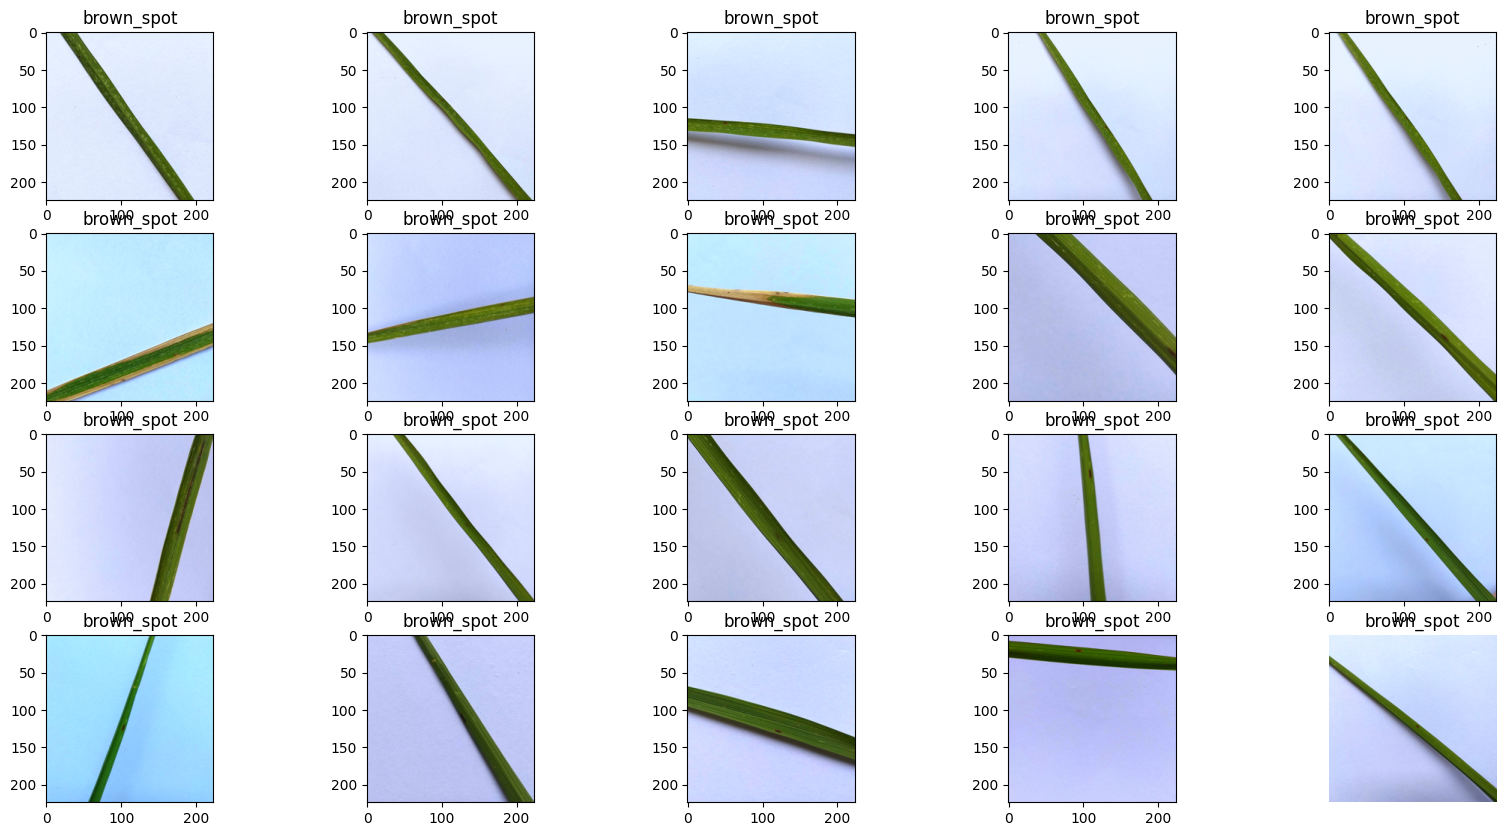

In [32]:
# Reference https://www.kaggle.com/code/mehmetlaudatekman/rice-leaf-pytorch-transfer-learning
random_sample_indexes = random.choices(range(len(dataset)),k=20)

fig, axis = plt.subplots(4,5, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        
        image,label = dataset[i]
        #print(image.T)
        image = (image - torch.min(image)) / (torch.max(image) - torch.min(image))
        ax.imshow(image.T)
        label = label_map[label]
        ax.set(title = f"{label}")
        plt.axis("off")
        '''
        npimg = image.numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
        label = label_map[label]
        ax.imshow(npimg)
        ax.set(title = f"{label}")
        plt.axis("off")
        '''

# 3. Model Selection ##
### Tried the below models:
DenseNet-121<br>
DenseNet-161<br>
DenseNet-201<br>
Vgg19<br>
ResNet-50<br>
ResNet-101<br>
Inception v3<br>
AlexNet<br>

In [36]:
# d121 = torchvision.models.densenet121(pretrained=True)
# d161 = torchvision.models.densenet161(pretrained=True)
# d201 = torchvision.models.densenet201(pretrained=True)
# v19 = torchvision.models.vgg19_bn(pretrained=True)
# v3 = torchvision.models.inception_v3(pretrained=True) # Inception v3 Be careful, expects (299,299) sized images and has auxiliary output
anet = torchvision.models.alexnet(pretrained=True) # input size == 224

# This will return how many features we'll have after flattening.
# num_features = v19.classifier[6].in_features
# num_features = r50.fc.in_features
# num_features = d201.classifier.in_features
# num_features = v3.fc.in_features
num_features = anet.classifier[6].in_features
num_features

4096

In [37]:
num_features

4096

In [ ]:
# get the last layer and add our output layer
# v3.fc = nn.Linear(num_features, 4)

In [38]:
# get the last layer and add our output layer
anet.classifier[6] = nn.Linear(num_features, 4) 

In [ ]:
# get the last layer and add our output layer
# layers = list(r101.children())[:-1]
# layers = list(v19.classifier.children())[:-1]

In [ ]:
# get the last layer and add our output layer
# from torchvision.models.resnet import resnet101
# model = resnet101(4).to('cuda')

# 4. Model fine tuning ##
### Add additinal layers:

In [ ]:
from torchvision.models import vgg19
from torchvision.models.resnet import resnet50
from torchvision.models.resnet import resnet101

# tried to add different layers and observe performance
'''
new_layers = nn.Sequential(
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.Dropout(0.5),  # Dropout layer with dropout probability of 0.2
                nn.Linear(512, 4)
                #nn.Softmax(dim=1) # Create a softmax module that applies softmax along the second dimension (i.e., dimension 1)       
             )

new_layers = nn.Sequential(
                nn.Flatten(),  # Flatten the output of the last convolutional layer
                
                nn.Linear(num_features, 1024),
                # nn.Linear(1920 * 7 * 7, 1024),  # Add a new linear layer with input size of 1920 * 7 * 7 and output size of 1024
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.5),  # Add a dropout layer to prevent overfitting

                nn.Linear(1024, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.5),  # Add a dropout layer to prevent overfitting

                nn.Linear(512, 4)  # Add the final linear layer with output size of num_classes
            )

new_layers = nn.Linear(num_features,4)            
layers.append(new_layers)

'''

# d201.classifier = nn.Sequential(*layers)
# v19.classifier = nn.Sequential(*layers)
# r101.fc = nn.Sequential(*layers)

# model = v19

In [39]:
model = anet.to('cuda')

### Freeze layers:

In [ ]:
# If set the requires_grad attribute of all parameters to True, they will update during training
for param in model.parameters():
    param.requires_grad = False

# 5. Adjust optimizer and learning rate


In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 6. Train the model ##

In [41]:
# reference：https://discuss.pytorch.org/t/how-to-get-the-vector-extract-the-feature-of-a-transfered-learned-network/28219
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# for drawing graph
acc_list, val_loss_list, precision_list, recall_list, f1_list = [],[],[],[],[]
train_acc_list, train_loss_list, train_precision_list, train_recall_list, train_f1_list = [],[],[],[],[]

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
  model.train()
  train_loss = 0
  train_predictions, train_targets = [], []

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    # outputs, x = model(inputs) # for inception v3
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
        
    train_loss += loss.item()
    _, preds = torch.max(outputs, 1)
    train_predictions.extend(preds.cpu().numpy())
    train_targets.extend(labels.cpu().numpy())

  model.eval()
  with torch.no_grad():
    val_loss = 0
    predictions, targets = [], []
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #print(loss.item())
        val_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        targets.extend(labels.cpu().numpy())

    # Calculate metrics
    # print('t',targets[:15])
    # print('p',predictions[:15])  
    # print(classification_report(targets, predictions))
    # print(len(targets))

    train_acc = accuracy_score(train_targets, train_predictions)
    train_loss /= len(train_loader)

    val_acc = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, average='weighted')
    recall = recall_score(targets, predictions, average='weighted')
    f1 = f1_score(targets, predictions, average='weighted')
    val_loss /= len(val_loader)

    # record data of train set
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    train_precision_list.append(precision_score(train_targets, train_predictions, average='weighted'))
    train_recall_list.append(recall_score(train_targets, train_predictions, average='weighted'))
    train_f1_list.append(f1_score(train_targets, train_predictions, average='weighted'))

    # record data of validation set
    acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}")
    #print(classification_report(targets, predictions))
  if epoch % 10 == 0:
    m_name = 'model_res101_add_layers.pth'
    # torch.save(model.state_dict(), DIR_MODEL + test_name)
    torch.save(model, DIR_MODEL + m_name)


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30
Train Loss: 1.0855, Train Accuracy: 0.5354
Validation Accuracy: 0.5783, Precision: 0.4613, Recall: 0.5783, F1 score: 0.5077
Epoch 2/30
Train Loss: 0.7625, Train Accuracy: 0.6646
Validation Accuracy: 0.5361, Precision: 0.6405, Recall: 0.5361, F1 score: 0.5381
Epoch 3/30
Train Loss: 0.6848, Train Accuracy: 0.7111
Validation Accuracy: 0.6386, Precision: 0.6318, Recall: 0.6386, F1 score: 0.6233
Epoch 4/30
Train Loss: 0.5546, Train Accuracy: 0.7697
Validation Accuracy: 0.6386, Precision: 0.6463, Recall: 0.6386, F1 score: 0.5873
Epoch 5/30
Train Loss: 0.4355, Train Accuracy: 0.8121
Validation Accuracy: 0.6747, Precision: 0.6854, Recall: 0.6747, F1 score: 0.6733
Epoch 6/30
Train Loss: 0.3248, Train Accuracy: 0.8687
Validation Accuracy: 0.6205, Precision: 0.6468, Recall: 0.6205, F1 score: 0.6255
Epoch 7/30
Train Loss: 0.3786, Train Accuracy: 0.8545
Validation Accuracy: 0.5904, Precision: 0.5889, Recall: 0.5904, F1 score: 0.5845
Epoch 8/30
Train Loss: 0.3552, Train Accuracy: 0.8586
V

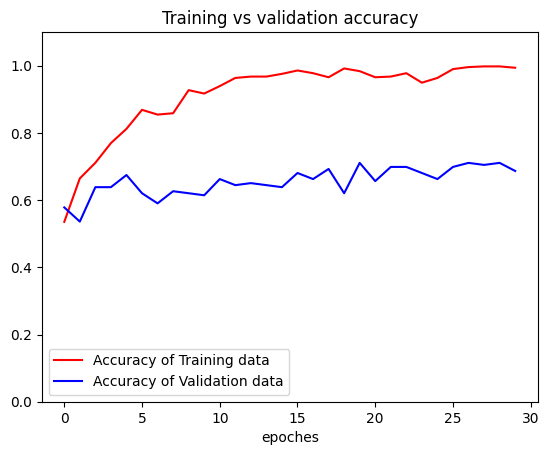

<Figure size 640x480 with 0 Axes>

In [42]:
from matplotlib.layout_engine import TightLayoutEngine
def plot(list1, list2, label1, label2, title, yl):
  epo = range(len(list1))
  plt.plot(epo, list1, 'r', label= label1)
  plt.plot(epo, list2, 'b', label= label2)
  plt.title(title)
  plt.legend(loc=0)
  plt.xlabel('epoches')
  plt.ylim(0,yl)
  plt.figure()
  plt.show()

plot(train_acc_list, acc_list, 'Accuracy of Training data', 'Accuracy of Validation data', 'Training vs validation accuracy',1.1 )

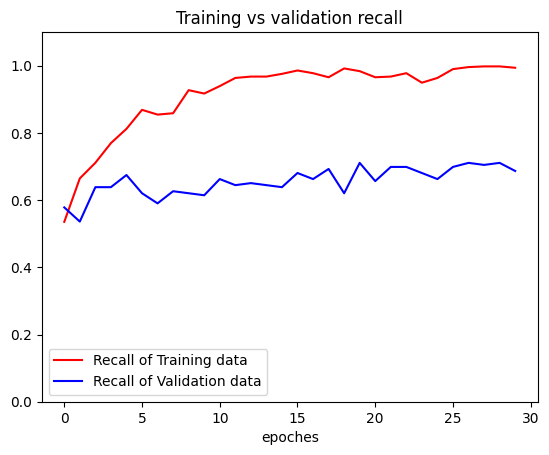

<Figure size 640x480 with 0 Axes>

In [43]:
plot(train_recall_list, recall_list, 'Recall of Training data', 'Recall of Validation data', 'Training vs validation recall',1.1 )

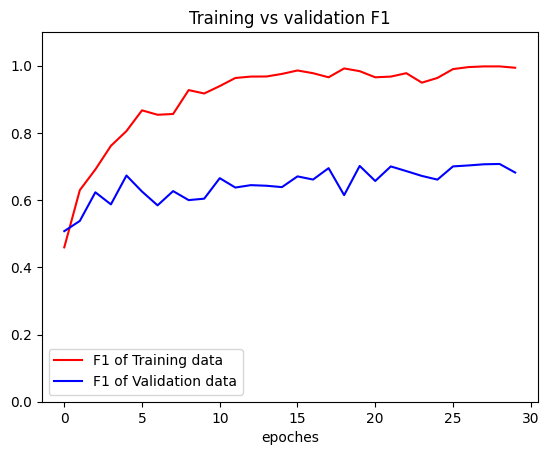

<Figure size 640x480 with 0 Axes>

In [44]:
plot(train_f1_list, f1_list, 'F1 of Training data', 'F1 of Validation data', 'Training vs validation F1',1.1 )

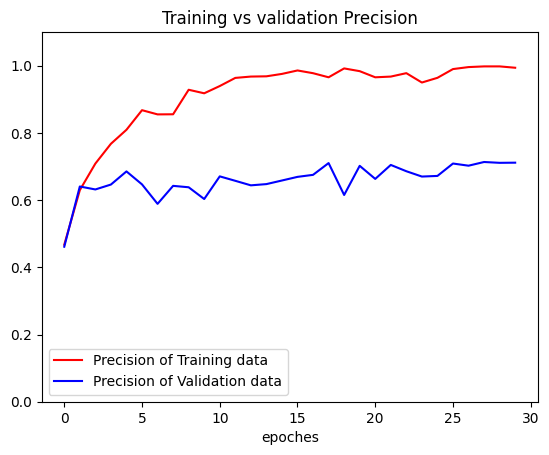

<Figure size 640x480 with 0 Axes>

In [45]:
plot(train_precision_list, precision_list, 'Precision of Training data', 'Precision of Validation data', 'Training vs validation Precision',1.1 )

## Findings:
- Based on the above attempts, the DenseNet-201 performs better than other models on this dataset.
- The DenseNet-201 without additioanl layers or frozen layers performs better.